# SegVeg Model Training on Google Colab

## Introduction
This notebook demonstrates the training of the SegVeg segmentation model described in the paper "SegVeg: Segmenting RGB Images into Green and Senescent Vegetation by Combining Deep and Shallow Methods". The model is designed to segment high-resolution RGB images into categories of green vegetation, senescent vegetation, and background.


## Setup
### Import Libraries
Import all necessary libraries like TensorFlow, NumPy, OpenCV, and Pandas. This setup ensures we have all the tools required for image manipulation, data handling, and machine learning.


In [6]:
!pip install --upgrade --force-reinstall torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.6.0%2Bcu118-cp311-cp311-linux_x86_64.whl.metadata (27 kB)
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.21.0%2Bcu118-cp311-cp311-linux_x86_64.whl.metadata (6.1 kB)
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.6.0%2Bcu118-cp311-cp311-linux_x86_64.whl.metadata (6.6 kB)
ERROR: Operation cancelled by user


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
!import cv2
!pip install torchviz
!pip install albumentations
!pip install timm

cudnn.benchmark = True
plt.ion()

/bin/bash: line 1: import: command not found
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.8

### Mount Google Drive
Mount your Google Drive to access the dataset directly from your drive, allowing seamless integration and data management without manual uploads.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preparation
## Load Data
Load images and their corresponding masks from the specified directories within Google Drive. Ensure that the data is correctly partitioned into training and validation sets.

### Data Preprocessing
Discuss the preprocessing steps applied to the data, such as resizing, normalization, and augmentation techniques to enhance the robustness of the model.

In [3]:
import os, random, numpy as np
from PIL import Image
from typing import Callable, Optional, Tuple, List

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
from albumentations import (
    HorizontalFlip, VerticalFlip, RandomRotate90,
    RandomBrightnessContrast, HueSaturationValue,
    Compose
)
from albumentations.pytorch import ToTensorV2
import glob, os, numpy as np
from PIL import Image
from typing import Optional, Callable, Tuple
import torch
from torch.utils.data import Dataset
from torchvision import transforms as T
from albumentations import Compose
from albumentations import (
    HorizontalFlip, VerticalFlip, RandomRotate90, RandomBrightnessContrast,
    HueSaturationValue, CLAHE, RandomGamma, GaussianBlur, Compose
)

In [4]:
class SegDataset(Dataset):
    def __init__(
        self,
        image_dir: str,
        mask_dir: str,
        aug: Optional[Compose] = None,
        img_transform: Optional[Callable] = None,
        mask_transform: Optional[Callable] = None,
    ):
        self.image_dir, self.mask_dir = image_dir, mask_dir
        self.fnames = sorted(os.listdir(image_dir))
        self.aug = aug
        self.img_tf = img_transform
        self.msk_tf = mask_transform


        self.mask_paths = [self._find_mask_path(f) for f in self.fnames]

    def _find_mask_path(self, img_fname: str) -> str:
        stem, _ = os.path.splitext(img_fname)
        # 1️⃣  try <stem>_mask.<ext>
        for ext in ("png", "jpg", "tif"):
            cand = os.path.join(self.mask_dir, f"{stem}_mask.{ext}")
            if os.path.isfile(cand):
                return cand
        # 2️⃣  try same filename (no “_mask”)
        for ext in ("png", "jpg", "tif"):
            cand = os.path.join(self.mask_dir, f"{stem}.{ext}")
            if os.path.isfile(cand):
                return cand
        raise FileNotFoundError(f"No mask found for image {img_fname}")

    def __len__(self): return len(self.fnames)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        img_path = os.path.join(self.image_dir, self.fnames[idx])
        msk_path = self.mask_paths[idx]

        img = np.array(Image.open(img_path).convert("RGB"))
        msk = np.array(Image.open(msk_path).convert("L"), dtype=np.uint8)

        if self.aug:
            out = self.aug(image=img, mask=msk)
            img, msk = out["image"], out["mask"]

        img = Image.fromarray(img) if isinstance(img, np.ndarray) else img
        msk = Image.fromarray(msk) if isinstance(msk, np.ndarray) else msk

        if self.img_tf: img = self.img_tf(img)
        if self.msk_tf: msk = self.msk_tf(msk)

        return img, msk




In [5]:
def build_img_transform(size: int = 512) -> T.Compose:
    return T.Compose([
        T.Resize((size, size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
    ])

def build_mask_transform(size: int = 512) -> T.Compose:
    return T.Compose([
        T.Resize((size, size), interpolation=T.InterpolationMode.NEAREST),
        T.ToTensor(),          # gives float tensor in [0,1]
    ])

def build_train_aug() -> Compose:
    return Compose([
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        RandomRotate90(p=0.5),
        HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        CLAHE(clip_limit=2.0, p=0.5),
        RandomGamma(gamma_limit=(80, 120), p=0.5),
        GaussianBlur(blur_limit=3, p=0.3),
    ])

In [6]:
def build_loaders(
    img_dir: str,
    msk_dir: str,
    batch_size: int = 32,
    val_ratio: float = 0.15,
    test_ratio: float = 0.15,
    num_workers: int = 4,
    seed: int = 42,
):

    # deterministic split
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    full_ds = SegDataset(
        img_dir, msk_dir,
        aug=None,  # added later per‑split
        img_transform=build_img_transform(),
        mask_transform=build_mask_transform()
    )

    n = len(full_ds)
    n_test = int(n * test_ratio)
    n_val  = int(n * val_ratio)
    n_train = n - n_val - n_test
    train_ds, val_ds, test_ds = random_split(
        full_ds, [n_train, n_val, n_test],
        generator=torch.Generator().manual_seed(seed)
    )

    # attach augmentations ONLY to training subset
    train_ds.dataset.aug = build_train_aug()

    def _make_loader(ds, shuffle):
        return DataLoader(
            ds, batch_size=batch_size, shuffle=shuffle,
            num_workers=num_workers, pin_memory=True, drop_last=shuffle
        )

    return (_make_loader(train_ds, True),
            _make_loader(val_ds, False),
            _make_loader(test_ds, False))

In [7]:
train_loader, val_loader, test_loader = build_loaders(
        "/content/drive/MyDrive/Colab Notebooks/crop/images",
        "/content/drive/MyDrive/Colab Notebooks/crop/annotations",
        batch_size=32,num_workers=12
        )

## Model Definition
### U-Net Model
Describe the architecture of the U-Net model used for initial segmentation. Include details on the layers, activation functions, and the rationale behind using U-Net for this task.

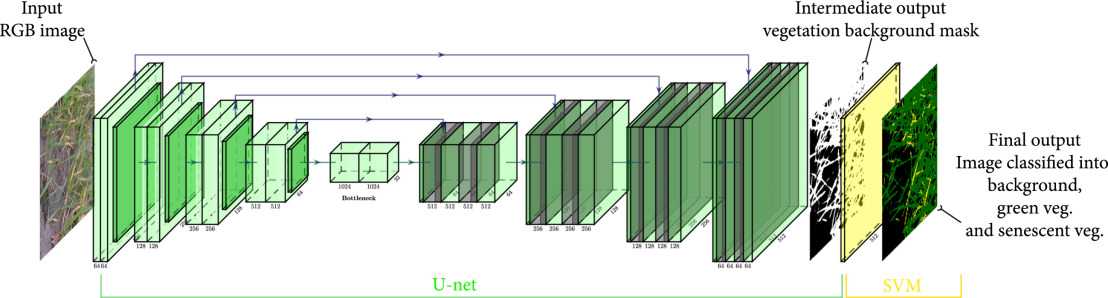

In [15]:


class DiceLoss(nn.Module):
    def __init__(self, eps: float = 1e-7):
        super().__init__()
        self.eps = eps

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        num = 2 * (probs * targets).sum(dim=(2, 3))
        den = (probs + targets).sum(dim=(2, 3)).clamp(min=self.eps)
        dice = 1 - (num + self.eps) / (den + self.eps)
        return dice.mean()



In [16]:
class ConvReLU(nn.Sequential):
    def __init__(self, in_ch, out_ch):
        super().__init__(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

In [17]:


class DecoderBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear",
                              align_corners=False)
        self.conv1 = ConvReLU(in_ch + skip_ch, out_ch)
        self.conv2 = ConvReLU(out_ch, out_ch)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        return self.conv2(x)

class FinalUpBlock(nn.Module):
    """last decoder stage (no skip)"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear",
                              align_corners=False)
        self.conv1 = ConvReLU(in_ch, out_ch)
        self.conv2 = ConvReLU(out_ch, out_ch)

    def forward(self, x):
        x = self.up(x)
        x = self.conv1(x)
        return self.conv2(x)

In [18]:
class EffB2Encoder(nn.Module):
    """Outputs: bottleneck (352 ch, 1/32) and 4 skip tensors."""
    def __init__(self, pretrained=True):
        super().__init__()
        # features_only=True → returns list of feature maps
        self.backbone = timm.create_model(
            'efficientnet_b2',
            pretrained=pretrained,
            features_only=True,
            out_indices=(0, 1, 2, 3, 4)  # 5 stages
        )
        # channels: [16, 24, 48, 120, 352]
        self._channels = [f['num_chs'] for f in self.backbone.feature_info]

    def forward(self, x):
        feats = self.backbone(x)          # len=5
        bottleneck = feats[-1]            # 352 ch, 16×16
        skips = feats[:-1]                # 4 skip maps (shallow → deep)
        return bottleneck, skips

class UNetEffB2(nn.Module):
    def __init__(self, pretrained_encoder=True):
        super().__init__()
        self.encoder = EffB2Encoder(pretrained=pretrained_encoder)

        # decoder channel plan (352→256→128→64→32→16)
        self.dec0 = DecoderBlock(352, 120, 256)   # 16→32
        self.dec1 = DecoderBlock(256,  48, 128)   # 32→64
        self.dec2 = DecoderBlock(128,  24,  64)   # 64→128
        self.dec3 = DecoderBlock( 64,  16,  32)   # 128→256
        self.dec4 = FinalUpBlock(32, 16)          # 256→512

        self.head = nn.Conv2d(16, 1, 3, padding=1)  # logits

    def forward(self, x):
        bottleneck, skips = self.encoder(x)
        x = self.dec0(bottleneck, skips[-1])  # skip 120 ch
        x = self.dec1(x, skips[-2])           # skip 48 ch
        x = self.dec2(x, skips[-3])           # skip 24 ch
        x = self.dec3(x, skips[-4])           # skip 16 ch
        x = self.dec4(x)                      # no skip
        return self.head(x)                   # 1×H×W logits


## Training
### Training Parameters
Define and explain the choice of loss functions, optimizers, and other hyperparameters like learning rate and batch size. Discuss the training environment specifics, including GPU settings if applicable.

In [19]:
def build_loss():
    return DiceLoss(), nn.BCEWithLogitsLoss()

def build_optimizer(model, lr_enc=1e-4, lr_dec=1e-3, weight_decay=1e-4):
    enc_params = []
    dec_params = []
    for name, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if name.startswith('encoder'):
            enc_params.append(p)
        else:
            dec_params.append(p)
    return torch.optim.Adam([
        {'params': enc_params, 'lr': lr_enc},
        {'params': dec_params, 'lr': lr_dec}
    ], weight_decay=weight_decay, amsgrad=True)

def step_lr_scheduler(optimizer, step_size=20, gamma=0.3):
    return torch.optim.lr_scheduler.StepLR(optimizer, step_size, gamma)

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNetEffB2(pretrained_encoder=True).to(device)

# dummy batch (B=2, 512×512)
x = torch.randn(2, 3, 512, 512).to(device)
y = torch.randint(0, 2, (2, 1, 512, 512), dtype=torch.float32).to(device)

dice_loss, bce_loss = build_loss()
logits = model(x)
loss = 0.5 * dice_loss(logits, y) + 0.5 * bce_loss(logits, y)

optimizer = build_optimizer(model)
loss.backward()
optimizer.step()

print("logits shape :", logits.shape)      # [2, 1, 512, 512]
print("total params :", sum(p.numel() for p in model.parameters())/1e6, "M")
print("loss value   :", loss.item())

logits shape : torch.Size([2, 1, 512, 512])
total params : 9.543251 M
loss value   : 0.6275378465652466


### Training Process
Outline the steps taken during the training process, including the use of callbacks for model checkpointing, early stopping, and any specific training strategies like transfer learning or fine-tuning.

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.ao.quantization as tq
import torch.serialization
import timm
import time

print("PyTorch Version:", torch.__version__)

####################
# A) MODEL DEFINITIONS
####################
class ConvReLU(nn.Sequential):
    def __init__(self, in_ch, out_ch):
        super().__init__(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

class DecoderBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
        self.conv1 = ConvReLU(in_ch + skip_ch, out_ch)
        self.conv2 = ConvReLU(out_ch, out_ch)
    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        return self.conv2(x)

class FinalUpBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
        self.conv1 = ConvReLU(in_ch, out_ch)
        self.conv2 = ConvReLU(out_ch, out_ch)
    def forward(self, x):
        x = self.up(x)
        x = self.conv1(x)
        return self.conv2(x)

class EffB2Encoder(nn.Module):
    """
    Outputs: bottleneck (352 ch, 1/32 scale) and 4 skip tensors.
    Using timm's EfficientNet-B2 with features_only=True.
    """
    def __init__(self, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(
            'efficientnet_b2',
            pretrained=pretrained,
            features_only=True,
            out_indices=(0,1,2,3,4)
        )
        # channels: [16, 24, 48, 120, 352]
        self._channels = [f['num_chs'] for f in self.backbone.feature_info]

    def forward(self, x):
        feats = self.backbone(x)
        bottleneck = feats[-1]
        skips = feats[:-1]  # 4 skip feature maps
        return bottleneck, skips

class UNetEffB2(nn.Module):
    def __init__(self, pretrained_encoder=True):
        super().__init__()
        self.encoder = EffB2Encoder(pretrained=pretrained_encoder)
        # decoder channel plan: 352->256->128->64->32->16
        # skip channels: [16, 24, 48, 120]
        self.dec0 = DecoderBlock(352, 120, 256)
        self.dec1 = DecoderBlock(256, 48, 128)
        self.dec2 = DecoderBlock(128, 24, 64)
        self.dec3 = DecoderBlock(64, 16, 32)
        self.dec4 = FinalUpBlock(32, 16)
        # final conv -> 1 channel (binary segmentation mask, e.g.)
        self.head = nn.Conv2d(16, 1, kernel_size=3, padding=1)

    def forward(self, x):
        bottleneck, skips = self.encoder(x)
        x = self.dec0(bottleneck, skips[-1])
        x = self.dec1(x,         skips[-2])
        x = self.dec2(x,         skips[-3])
        x = self.dec3(x,         skips[-4])
        x = self.dec4(x)
        return self.head(x)

PyTorch Version: 2.6.0+cu118


In [22]:
import torch

model = UNetEffB2(pretrained_encoder=True).cuda()  # Assume UNetEffB2 is correctly defined somewhere
dice, bce = build_loss()  # Assume build_loss() properly returns the loss functions
optim = build_optimizer(model)  # Assume build_optimizer() properly sets up the optimizer
sched = step_lr_scheduler(optim)  # Assume step_lr_scheduler() sets up the learning rate scheduler

best_val_loss = float('inf')
early_stopping_counter = 0
early_stopping_limit = 10  # Stop if no improvement after 10 epochs

train_losses = []
val_losses = []

for epoch in range(50):
    model.train()
    train_loss = 0
    for imgs, masks in train_loader:  # supply your own DataLoader
        imgs, masks = imgs.cuda(), masks.cuda()
        logits = model(imgs)
        loss = 0.5 * dice(logits, masks) + 0.5 * bce(logits, masks)


        optim.zero_grad()
        loss.backward()
        optim.step()

        train_loss += loss.item() * imgs.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, masks in val_loader:  # Assume a validation DataLoader is available
            imgs, masks = imgs.cuda(), masks.cuda()
            logits = model(imgs)
            loss = 0.5 * dice(logits, masks) + 0.5 * bce(logits, masks)
            val_loss += loss.item() * imgs.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch {epoch + 1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= early_stopping_limit:
        print("Early stopping triggered.")
        break

    sched.step()  # Update the learning rate



Epoch 1, Training Loss: 0.6431, Validation Loss: 0.8247
Epoch 2, Training Loss: 0.5035, Validation Loss: 0.5444
Epoch 3, Training Loss: 0.3906, Validation Loss: 0.3672
Epoch 4, Training Loss: 0.3022, Validation Loss: 0.2995
Epoch 5, Training Loss: 0.2316, Validation Loss: 0.2282
Epoch 6, Training Loss: 0.1836, Validation Loss: 0.1796
Epoch 7, Training Loss: 0.1461, Validation Loss: 0.1589
Epoch 8, Training Loss: 0.1236, Validation Loss: 0.1321
Epoch 9, Training Loss: 0.1089, Validation Loss: 0.1264
Epoch 10, Training Loss: 0.1011, Validation Loss: 0.1166
Epoch 11, Training Loss: 0.0925, Validation Loss: 0.1110
Epoch 12, Training Loss: 0.0907, Validation Loss: 0.1052
Epoch 13, Training Loss: 0.0845, Validation Loss: 0.1018
Epoch 14, Training Loss: 0.0822, Validation Loss: 0.1010
Epoch 15, Training Loss: 0.0821, Validation Loss: 0.0994
Epoch 16, Training Loss: 0.0802, Validation Loss: 0.1009
Epoch 17, Training Loss: 0.0788, Validation Loss: 0.0989
Epoch 18, Training Loss: 0.0766, Validat

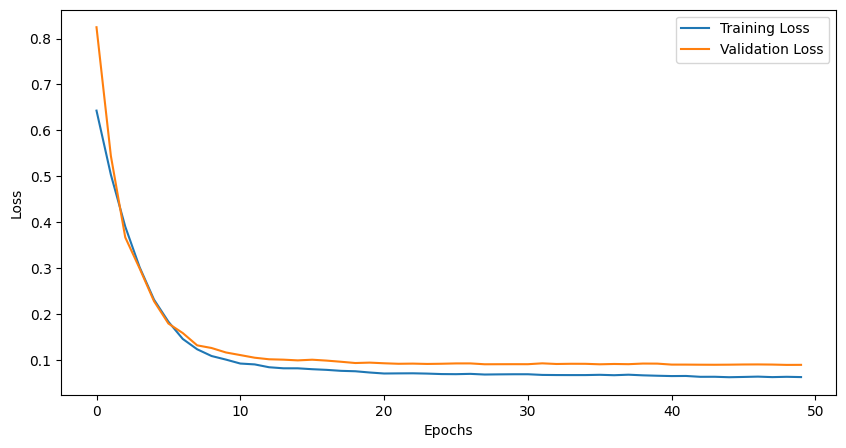

In [23]:
# Optionally plot training and validation loss curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

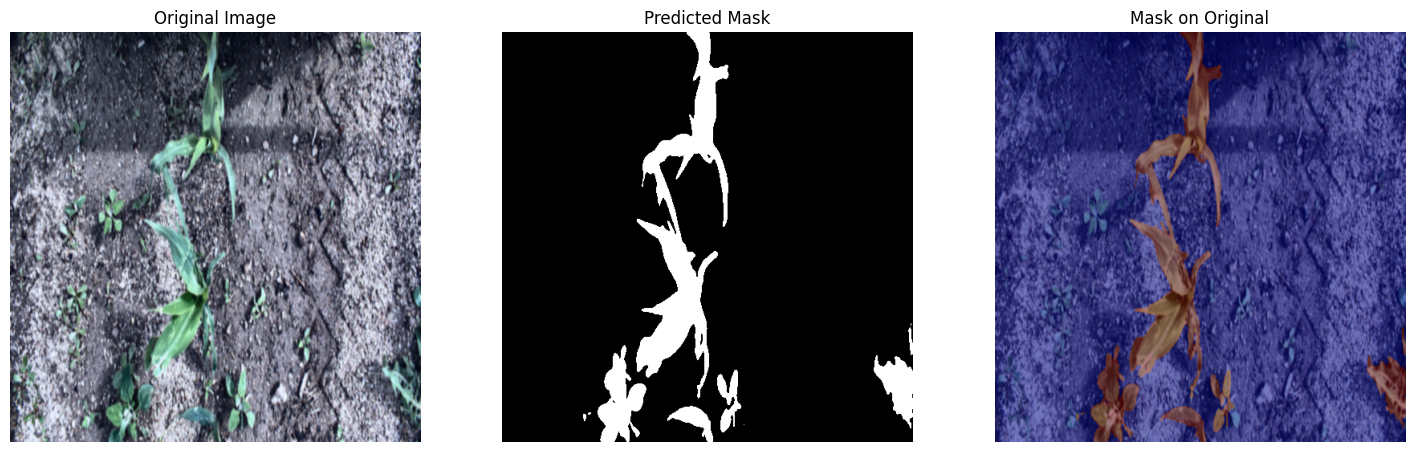

In [24]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
from torchvision import transforms

# Assuming the model and DataLoader are set up:

# Load the model
#model = UNetEffB2(pretrained_encoder=True).cuda()
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Pick a random batch from the test DataLoader
random_index = random.randint(0, len(test_loader)-1)
for i, (imgs, masks) in enumerate(test_loader):
    if i == random_index:
        imgs, masks = imgs.cuda(), masks.cuda()
        with torch.no_grad():
            logits = model(imgs)
            probabilities = torch.sigmoid(logits)
            predicted_masks = (probabilities > 0.5).float()  # Convert probabilities to binary mask

        # Choose a random image from the batch
        image_index = random.randint(0, imgs.size(0) - 1)
        original_image = imgs[image_index].cpu().permute(1, 2, 0).numpy()
        original_mask = masks[image_index].cpu().squeeze().numpy()
        predicted_mask = predicted_masks[image_index].cpu().squeeze().numpy()

        # Normalize the original image for better visualization
        original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())

        # Function to plot images
        def plot_images(original, mask, overlay):
            fig, ax = plt.subplots(1, 3, figsize=(18, 6))
            ax[0].imshow(original)
            ax[0].set_title('Original Image')
            ax[0].axis('off')

            ax[1].imshow(mask, cmap='gray')
            ax[1].set_title('Predicted Mask')
            ax[1].axis('off')

            ax[2].imshow(original)
            ax[2].imshow(mask, alpha=0.5, cmap='jet')  # Overlay with transparency
            ax[2].set_title('Mask on Original')
            ax[2].axis('off')

            plt.show()

        # Plot the images
        plot_images(original_image, predicted_mask, original_image)

        break  # Stop after processing one random batch

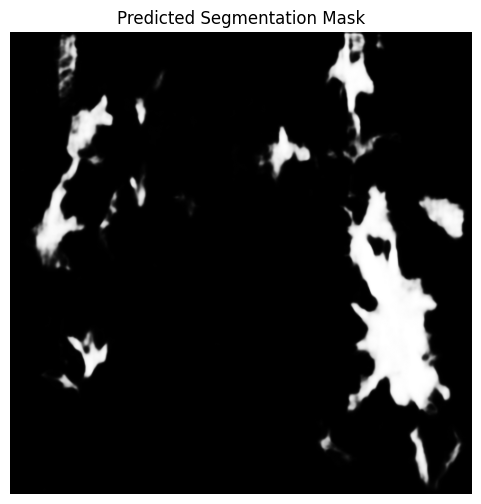

In [33]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and prepare the model
model = UNetEffB2(pretrained_encoder=True).cuda()
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Define the image processing steps
def process_image(image_path, target_size=512):
    # Load the image
    image = Image.open(image_path).convert('RGB')

    # Resize and convert to tensor
    transform = transforms.Compose([
        transforms.Resize((target_size, target_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])

    return transform(image).unsqueeze(0)  # Add batch dimension

# Perform inference
def infer(model, image_tensor):
    with torch.no_grad():
        image_tensor = image_tensor.cuda()  # Move to GPU
        logits = model(image_tensor)
        probabilities = torch.sigmoid(logits)
        return probabilities.cpu().squeeze(0).squeeze(0)  # Remove batch and channel dims

# Load, process, and predict
image_path = '/content/8.png'  # Adjust this path
image_tensor = process_image(image_path)
prediction_mask = infer(model, image_tensor)

# Display the prediction
plt.figure(figsize=(6, 6))
plt.imshow(prediction_mask, cmap='gray')
plt.title('Predicted Segmentation Mask')
plt.axis('off')
plt.show()

#Qauntization and Benchmarks

## Function to benchmark the models

In [ ]:
import time
import torch

def benchmark_model(model, test_loader, device=torch.device('cuda')):
    dice, bce = build_loss()  # Make sure these are correctly defined somewhere
    model.eval()
    model.to(device)

    start_time = time.time()
    total_loss = 0

    with torch.no_grad():
        for img, mask in test_loader:
            img, mask = img.to(device), mask.to(device)
            logits = model(img)
            loss = 0.5 * dice(logits, mask) + 0.5 * bce(logits, mask)
            total_loss += loss.item() * img.size(0)

    total_time = time.time() - start_time
    avg_loss = total_loss / len(test_loader.dataset)
    avg_time_per_image = total_time / len(test_loader.dataset)
    fps = 1 / avg_time_per_image if avg_time_per_image > 0 else 0  # Calculate FPS

    return avg_loss, total_time, avg_time_per_image, fps


## Bare Model(no Quant)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
bare_model = model  # Assuming 'model' is your U-Net or any other model loaded and defined elsewhere

bare_model_loss, bare_model_total_inftime, bare_model_avg_inftime_per_image, bare_model_fps = benchmark_model(bare_model, test_loader, device=device)
print("Bare Model Loss:", bare_model_loss)
print("Bare Model Total Inference Time:", bare_model_total_inftime)
print("Bare Model Average Inference Time per Image:", bare_model_avg_inftime_per_image)
print("Bare Model FPS (Frames Per Second):", bare_model_fps)

Bare Model Loss: 0.1326581232855261
Bare Model Total Inference Time: 7.473712921142578
Bare Model Average Inference Time per Image: 0.013204439790004555
Bare Model FPS (Frames Per Second): 75.73210343667712


## Save and Export Model
Instructions on how to save the trained model and predictions for deployment or further testing. Mention the file formats used and any considerations for model deployment.

In [ ]:
!pip install onnx
!pip install onnxruntime

In [ ]:
import torch
import torch.onnx

# Load the model
model = UNetEffB2(pretrained_encoder=True).cuda()
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Create a dummy input tensor matching the input size the model expects (e.g., 1x3x512x512)
dummy_input = torch.randn(1, 3, 512, 512, device='cuda')

# Set the path for the ONNX file
onnx_path = "output_model.onnx"

# Export the model
torch.onnx.export(model,               # model being run
                  dummy_input,         # model input (or a tuple for multiple inputs)
                  onnx_path,           # where to save the model (can be a file or file-like object)
                  export_params=True,  # store the trained parameter weights inside the model file
                  opset_version=11,    # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names=['input'],   # the model's input names
                  output_names=['output'],  # the model's output names
                  dynamic_axes={'input': {0: 'batch_size'},  # variable length axes
                                'output': {0: 'batch_size'}})

print(f"Model has been converted to ONNX and saved at {onnx_path}")